In [35]:
import re
import pandas as pd
import numpy as np
import akshare as ak
import baostock as bs
from utils import get_index_components, get_csindex_components, get_history_k, get_rs_target, camel_to_snake, df_multi_merge
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_bs = get_history_k(['sh.600900','sz.000001'],'2020-01-01','2020-03-02')
# df_bs.groupby('code').apply(lambda df:(df.sort_values('date')['pct_chg']/100+1).prod()).to_dict()
# return_daily_dict_tmp = df_bs.groupby('code').apply(lambda df:(df.sort_values('date')['pct_chg']/100+1).values).to_dict()
# np.sum(np.array(list(return_daily_dict_tmp.values())).transpose()*np.array([0.5,0.5]), axis=1)


KeyboardInterrupt: 

In [76]:
# pd.date_range(start='2020-11-15', end='2020-12-31', inclusive='right').strftime('%Y-%m-%d').tolist()

In [129]:
def get_csindex_components_history(index_code, qdate, components_fixed=None):
    if components_fixed is None:
        return get_csindex_components(index_code)
    else:
        return components_fixed

def get_decision_dates(stt_date, end_date, freq='year'):
    # 获取所有的交易日列表
    active_date_list = get_history_k(['sh.000001'],'2000-01-01','2100-12-31')['date'].astype(str).values.tolist()

    if freq=='month':
        target_list_pre = [stt_date]+pd.date_range(start=stt_date, end=end_date, freq='M').strftime('%Y-%m-%d').tolist()+[end_date]
        target_list = [active_date_list[np.where(np.array(active_date_list) <= d)[0][-1]] for d in target_list_pre]
    elif freq=='year':
        target_list_pre = [stt_date]+pd.date_range(start=stt_date, end=end_date, freq='Y').strftime('%Y-%m-%d').tolist()+[end_date]
        target_list = [active_date_list[np.where(np.array(active_date_list) <= d)[0][-1]] for d in target_list_pre]
    elif freq=='half-year':
        target_list_pre = [stt_date]+pd.date_range(start=stt_date, end=end_date, freq='6M').strftime('%Y-%m-%d').tolist()+[end_date]
        target_list = [active_date_list[np.where(np.array(active_date_list) <= d)[0][-1]] for d in target_list_pre]
    elif freq=='quarter':
        target_list_pre = [stt_date]+pd.date_range(start=stt_date, end=end_date, freq='Q').strftime('%Y-%m-%d').tolist()+[end_date]
        target_list = [active_date_list[np.where(np.array(active_date_list) <= d)[0][-1]] for d in target_list_pre]
    else:
        target_list_pre = [stt_date]+pd.date_range(start=stt_date, end=end_date).strftime('%Y-%m-%d').tolist()+[end_date]
        target_list = [d for d in target_list_pre if d in active_date_list]
    return target_list

def stock_selector(df_all, decision_date, topk=10):
    #------------------------------------------------
    #
    #   规则（按顺序执行）
    #   -- 1. pe在0-30之间
    #   -- 2. 3年股票价格增长趋势为正
    #   -- 3. 连续3年股息率top(3*K)
    #   -- 4. 市值最小的topK
    #
    #------------------------------------------------
    df_search = df_all[df_all['date']==decision_date]

    df_search[df_search['pe_ttm'].between(0,30)]

    trend_stt_date = np.datetime64(decision_date)-pd.DateOffset(years=3)
    df_search['trend_stt_date']=trend_stt_date
    df_search = pd.merge_asof(df_search.sort_values('trend_stt_date'), df_all[['date','code','close']].sort_values('date').rename(columns={"date":"trend_stt_date","close":"close_trend_stt"}), on='trend_stt_date',by='code')
    df_search['trend_factor'] = df_search['close']/df_search['close_trend_stt']
    df_search = df_search[df_search['trend_factor']>0]

    df_search = df_search.sort_values('dvd_ratio', ascending=False).head(3*topk)

    df_ = df_search.sort_values('size', ascending=False).head(topk)
    
    return df_['code'].values.tolist()

def stock_allocator(stock_list, method='eq'):
    weight = 1/len(stock_list)
    weight_dict = {s:weight for s in stock_list}
    return weight_dict


def backtesting(index_code, stt_date, end_date, df_all, decision_freq='year', stockselect_topk=10, dvd_win_min=3):
    # 获取A股stt_date和end_date之间的交易日数据
    active_date_list = get_history_k(['sh.000001'],stt_date,end_date,fields="date,code")['date'].astype(str).values.tolist()
    active_date_ses = pd.Series(active_date_list)

    # 获取总的股票池子
    codes_pool = get_csindex_components(index_code)
    decision_dates = get_decision_dates(stt_date, end_date)

    # 开始回测计算
    df_portfolio_list = []
    for i in range(len(decision_dates)-1):
        stt_date_tmp = decision_dates[i]
        end_date_tmp = decision_dates[i+1]
        
        date_list_tmp = active_date_ses[active_date_ses.between(stt_date_tmp, end_date_tmp,inclusive='right')]
        # print(i,'--',len(date_list_tmp),":",stt_date_tmp," -> ",end_date_tmp)
        # 获取当前日期的股票选择池
        code_list_tmp = get_csindex_components_history(index_code, stt_date_tmp, components_fixed=codes_pool)
        # 选出股票
        stock_selected_list_tmp = stock_selector(df_all, stt_date_tmp, stockselect_topk)
        # 得到选出股票的投资权重
        weight_dict_tmp = stock_allocator(stock_selected_list_tmp)
        # 获取选出股票在该投资period内的所有k线数据
        df_tmp = df_all[(df_all['code'].isin(stock_selected_list_tmp))&(df_all['date']>np.datetime64(stt_date_tmp))&(df_all['date']<=np.datetime64(end_date_tmp))]
        # 得到选出的每只股票的日收益系数list
        return_daily_dict_tmp = df_tmp.groupby('code').apply(lambda df:(df.sort_values('date')['pct_chg']/100+1).values).to_dict()
        # 计算portfolio的daily收益系数
        portfolio_daily_list_tmp = np.sum(np.array([return_daily_dict_tmp[s] for s in stock_selected_list_tmp]).transpose()*np.array([weight_dict_tmp[s] for s in stock_selected_list_tmp]), axis=1)
        # 给第一天和最后一天扣除掉手续费
        portfolio_daily_list_tmp[0] = portfolio_daily_list_tmp[0]-0.0006
        portfolio_daily_list_tmp[-1] = portfolio_daily_list_tmp[-1]-0.0012
        # 组装成df
        df_portfolio_tmp = pd.DataFrame({"date":date_list_tmp, "return":portfolio_daily_list_tmp})
        df_portfolio_list.append(df_portfolio_tmp)

    df_portfolio = pd.concat(df_portfolio_list)
    df_portfolio['return_cum'] = df_portfolio['return'].cumprod()
    return df_portfolio
    

In [15]:
def get_profit_df(stock_list, stt_date, end_date):
    bs.login()
    all_output_list = []
    yq_list = [(dd.year, dd.quarter) for dd in pd.date_range(stt_date, end_date, freq='Q')]
    for (y, q) in yq_list:
        all_output_list.append(get_rs_target(stock_list, y, q, 'profit'))
    df_output = pd.concat(all_output_list)
    # 格式转换
    df_output['pubDate'] = df_output['pubDate'].astype('datetime64[ns]')
    df_output['statDate'] = df_output['statDate'].astype('datetime64[ns]')
    for col in np.setdiff1d(df_output.columns, ['code', 'pubDate', 'statDate']):
        df_output[col] = pd.to_numeric(df_output[col])
    # 字段名转换
    df_output.columns = df_output.columns.map(camel_to_snake)
    bs.logout()
    return df_output

def get_dividend(code_list, stt_y, end_y, yearType='report'):
    bs.login()
    rs_list = []
    for code in code_list:
        for y in np.arange(stt_y, end_y+1):
            rs_dividend = bs.query_dividend_data(code=code, year=str(y), yearType=yearType)
            while (rs_dividend.error_code == '0') & rs_dividend.next():
                rs_list.append(rs_dividend.get_row_data())
    df_output = pd.DataFrame(rs_list, columns=rs_dividend.fields)
    df_output.columns = df_output.columns.map(camel_to_snake)
    bs.logout()
    return df_output


index_code='000922'
stt_date = '2020-01-01'
end_date = '2024-12-11'
decision_freq='year'
stockselect_topk = 10
dvd_win_min = 3


# 获取总的股票池子
codes_pool = get_csindex_components(index_code)
decision_dates = get_decision_dates(stt_date, end_date)
all_stt_date = ((pd.to_datetime(decision_dates[0]) - pd.DateOffset(years=dvd_win_min)).date()).strftime('%Y-%m-%d')
df_all = get_history_k(codes_pool, all_stt_date, decision_dates[-1], fields="date,code,close,pctChg,peTTM")
df_all['pct_chg'] = df_all['pct_chg'].fillna(0)
df_all['close'] = df_all['close'].fillna(method='ffill').fillna(method='bfill')

# 计算分红因子df
dvd_stt_year = (pd.to_datetime(stt_date) - pd.DateOffset(years=dvd_win_min)).year
dvd_end_year = pd.to_datetime(end_date).year
df_dvd = get_dividend(codes_pool, dvd_stt_year, dvd_end_year)
df_dvd['date'] = df_dvd['divid_operate_date'].astype('datetime64[ns]')
df_dvd['year'] = df_dvd['date'].dt.year
df_dvd = pd.merge(pd.DataFrame([(y, c) for y in np.arange(dvd_stt_year, df_dvd['year'].max()+1) for c in codes_pool], columns=['year', 'code']),df_dvd,on=['year','code'],how='outer')[['code','year','date','divid_cash_ps_before_tax']]
df_dvd.loc[df_dvd['date'].isna(),'date'] = (df_dvd.loc[df_dvd['date'].isna(),'year'].astype(str)+"-06-30").astype('datetime64[ns]')
df_dvd_plus = pd.merge_asof(df_dvd.sort_values('date'),df_all.sort_values('date')[['code','date','close']],by='code',on='date')
df_dvd_plus['divid_cash_ps_before_tax'] = df_dvd_plus['divid_cash_ps_before_tax'].replace('',np.nan).astype(float)
df_dvd_plus['dvd_ratio'] = df_dvd_plus['divid_cash_ps_before_tax']/df_dvd_plus['close']
## 计算3步长的移动平均
df_dvd_plus_core = df_dvd_plus.groupby('code')[['dvd_ratio','year']].rolling(window=dvd_win_min, min_periods=dvd_win_min,on='year').mean().fillna(0).reset_index(level=0)
df_dvd_plus_core = pd.merge(df_dvd_plus_core, df_dvd_plus[['code','year','date']], on=['code','year'],how='left')
df_dvd_plus_core.drop(columns=['year'], inplace=True)
df_all_merge = pd.merge_asof(df_all.sort_values('date'), df_dvd_plus_core.sort_values('date'), on='date', by='code')

# 计算市值因子df
prf_stt_date = (pd.to_datetime(stt_date) - pd.DateOffset(months=6)).strftime('%Y-%m-%d')
df_profit = get_profit_df(codes_pool,prf_stt_date,end_date)
df_profit_plus = pd.merge_asof(df_all[['code','date','pe_ttm']].sort_values('date'), df_profit[['code','pub_date','total_share','eps_ttm']].sort_values('pub_date').rename(columns={"pub_date":"date"}), on='date', by='code')
df_profit_plus['size'] = df_profit_plus['pe_ttm']*df_profit_plus['total_share']*df_profit_plus['eps_ttm']
df_profit_plus_core = df_profit_plus[['code','date','size']]
df_all_merge = pd.merge(df_all_merge, df_profit_plus_core, on=['date','code'], how='left')



login success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
[Errno 9] Bad file descriptor
接收数据异常，请稍后再试。


In [116]:
def calc_annualreturn(r_list):
    # r_list: 每日收益
    len_ = len(r_list)
    r_cum = np.prod(r_list)
    i = (np.exp(np.log(r_cum)/len_))**242-1
    return i 

def calc_maxdrawdown(r_list):
    # r_list: 每日累积收益
    r_array = np.array(r_list)
    peak = np.maximum.accumulate(r_array)  # Running maximum
    drawdown = (r_array - peak) / peak     # Drawdown from peak
    max_drawdown = np.min(drawdown)        # Maximum drawdown
    return abs(max_drawdown)               # Return positive value


def calc_sharperatio(daily_returns):
    # Calculate annualized Sharpe Ratio assuming 252 trading days
    sharpe_ratio = np.sqrt(252) * np.mean(daily_returns) / np.std(daily_returns)
    return sharpe_ratio


login success!
logout success!
login success!
logout success!
AR: 0.15450170023876653
MDD: 0.18304044260955218
SP: 1480.5867077716698


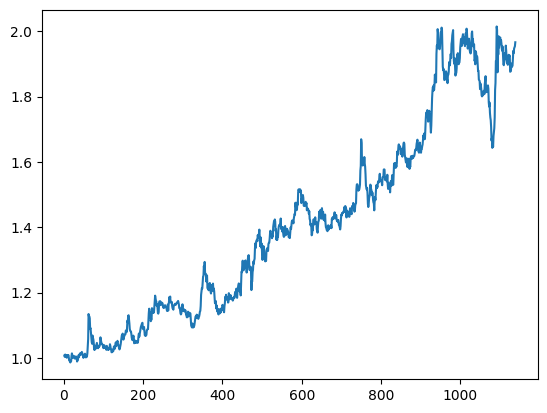

In [131]:
## 
df_portfolio = backtesting('000922','2020-04-01','2024-12-11', df_all_merge)
df_portfolio['return_cum'].plot()
print(f"AR: {calc_annualreturn(df_portfolio['return'].tolist())}")
print(f"MDD: {calc_maxdrawdown(df_portfolio['return_cum'].tolist())}")
print(f"SP: {calc_sharperatio(df_portfolio['return'].tolist())}")



In [20]:
df_all_merge

,date,code,close,pct_chg,pe_ttm,dvd_ratio,size
0,2017-01-03,sh.600000,9.379753,0.555214,6.510568,NaN,NaN
1,2017-01-03,sh.600048,6.578781,0.657168,8.390444,NaN,NaN
2,2017-01-03,sh.600674,6.869829,0.344824,11.078647,NaN,NaN
3,2017-01-03,sh.601998,4.505477,5.304215,7.722031,NaN,NaN
4,2017-01-03,sh.600019,4.005389,0.000000,23.978715,NaN,NaN
...,...,...,...,...,...,...,...
188414,2024-12-11,sh.600295,10.200000,1.291000,13.549716,0.119221,2.854751e+10
188415,2024-12-11,sz.000090,4.570000,2.008900,10.430153,0.067284,8.539258e+09
188416,2024-12-11,sz.000157,7.180000,0.279300,16.440227,0.052137,6.230804e+10
188417,2024-12-11,sh.601997,6.120000,-0.487800,4.244548,0.056544,2.237594e+10


In [96]:
decision_date="2020-04-30"


df_search = df_all_merge[df_all_merge['date']==decision_date]
#------------------------------------------------
#
#   规则（按顺序执行）
#   -- 1. pe在0-30之间
#   -- 2. 3年股票价格增长趋势为正
#   -- 3. 连续3年股息率top(3*K)
#   -- 4. 市值最小的topK
#
#------------------------------------------------

df_search[df_search['pe_ttm'].between(0,30)]

trend_stt_date = np.datetime64(decision_date)-pd.DateOffset(years=3)
df_search['trend_stt_date']=trend_stt_date
df_search = pd.merge_asof(df_search.sort_values('trend_stt_date'), df_all_merge[['date','code','close']].sort_values('date').rename(columns={"date":"trend_stt_date","close":"close_trend_stt"}), on='trend_stt_date',by='code')
df_search['trend_factor'] = df_search['close']/df_search['close_trend_stt']
df_search = df_search[df_search['trend_factor']>0]

df_search = df_search.sort_values('dvd_ratio', ascending=False).head(3*topk)

df_search.sort_values('size', ascending=True).head(topk)

,date,code,close,pct_chg,pe_ttm,dvd_ratio,size,trend_stt_date,close_trend_stt,trend_factor
73,2020-04-30,sh.603878,4.499502,1.8132,11.051486,0.078636,3.214659e+09,2017-04-30,7.195777,0.625298
63,2020-04-30,sz.002003,3.295662,1.8349,14.298058,0.098064,4.155623e+09,2017-04-30,4.479514,0.735719
79,2020-04-30,sh.600395,3.891825,1.1858,9.130524,0.074618,8.473859e+09,2017-04-30,4.678303,0.831888
62,2020-04-30,sz.000789,11.779819,-0.0681,8.335624,0.065434,1.169747e+10,2017-04-30,4.667145,2.523988
47,2020-04-30,sz.000090,4.700164,0.6299,5.540231,0.056099,1.194000e+10,2017-04-30,4.500425,1.044382
38,2020-04-30,sh.601636,4.207900,2.9354,10.894351,0.077483,1.413442e+10,2017-04-30,2.941897,1.430335
78,2020-04-30,sh.600873,3.597234,0.8850,15.861158,0.090261,1.415557e+10,2017-04-30,4.536014,0.793038
48,2020-04-30,sh.600325,5.111893,2.1309,5.024019,0.073423,1.420654e+10,2017-04-30,5.625420,0.908713
92,2020-04-30,sz.002110,5.791028,1.8207,5.543283,0.159919,1.782296e+10,2017-04-30,5.653682,1.024293
37,2020-04-30,sh.600808,2.220154,3.5573,14.190219,0.064999,2.017576e+10,2017-04-30,2.351672,0.944075


In [93]:
trend_stt_date = np.datetime64(decision_date)-pd.DateOffset(years=3)
df_search['trend_stt_date']=trend_stt_date
df_search = pd.merge_asof(df_search.sort_values('trend_stt_date'), df_all_merge[['date','code','close']].sort_values('date').rename(columns={"date":"trend_stt_date","close":"close_trend_stt"}), on='trend_stt_date',by='code')
df_search
# df_search['trend_factor'] = df_search['close']/df_search['close_trend_stt']
# df_search = df_search[df_search['trend_factor']>0]


,date,code,close,pct_chg,pe_ttm,dvd_ratio,size,trend_stt_date,close_trend_stt
0,2019-12-30,sh.600461,4.613901,0.5076,12.475040,0.000000,5.596388e+09,2016-12-30,NaN
1,2019-12-30,sz.000581,14.443409,-0.1062,9.185549,0.066061,1.898845e+10,2016-12-30,NaN
2,2019-12-30,sh.600782,3.892015,1.6097,3.497881,0.026601,1.610305e+10,2016-12-30,NaN
3,2019-12-30,sh.600919,5.142158,0.2782,5.667111,0.046977,8.323569e+10,2016-12-30,NaN
4,2019-12-30,sz.000090,3.839571,0.7722,11.390339,0.056099,9.753805e+09,2016-12-30,NaN
...,...,...,...,...,...,...,...,...,...
92,2019-12-30,sz.002443,5.659170,-0.1501,14.281221,0.018613,3.461558e+09,2016-12-30,NaN
93,2019-12-30,sz.002110,7.296535,2.8058,5.407484,0.159919,2.245644e+10,2016-12-30,NaN
94,2019-12-30,sh.601328,4.116033,0.3559,5.476989,0.071465,4.188418e+11,2016-12-30,NaN
95,2019-12-30,sh.600177,4.932921,1.4577,7.908311,0.108811,3.489763e+10,2016-12-30,NaN


In [94]:
df_all_merge

,date,code,close,pct_chg,pe_ttm,dvd_ratio,size
0,2017-01-03,sh.600000,9.379753,0.555214,6.510568,NaN,NaN
1,2017-01-03,sh.600048,6.578781,0.657168,8.390444,NaN,NaN
2,2017-01-03,sh.600674,6.869829,0.344824,11.078647,NaN,NaN
3,2017-01-03,sh.601998,4.505477,5.304215,7.722031,NaN,NaN
4,2017-01-03,sh.600019,4.005389,0.000000,23.978715,NaN,NaN
...,...,...,...,...,...,...,...
188414,2024-12-11,sh.600295,10.200000,1.291000,13.549716,0.119221,2.854751e+10
188415,2024-12-11,sz.000090,4.570000,2.008900,10.430153,0.067284,8.539258e+09
188416,2024-12-11,sz.000157,7.180000,0.279300,16.440227,0.052137,6.230804e+10
188417,2024-12-11,sh.601997,6.120000,-0.487800,4.244548,0.056544,2.237594e+10


In [89]:
df_all_merge[df_all_merge['date']==decision_date]

,date,code,close,pct_chg,pe_ttm,dvd_ratio,size
69162,2019-12-30,sh.600461,4.613901,0.5076,12.475040,0.000000,5.596388e+09
69163,2019-12-30,sh.600064,5.356162,2.8511,7.301087,0.047846,1.203822e+10
69164,2019-12-30,sh.600674,8.475778,0.8247,12.554093,0.039088,4.305294e+10
69165,2019-12-30,sh.600019,4.246197,1.2324,8.717478,0.077960,1.280781e+11
69166,2019-12-30,sh.600873,3.502569,1.6018,12.227944,0.090261,1.378306e+10
...,...,...,...,...,...,...,...
69254,2019-12-30,sh.601818,3.263267,-1.1261,6.178029,0.054301,2.304282e+11
69255,2019-12-30,sh.600273,8.620194,1.6349,13.503302,0.021963,1.603225e+10
69256,2019-12-30,sh.600546,4.854188,1.4218,20.717461,0.000000,1.272739e+10
69257,2019-12-30,sh.600295,3.338998,1.5927,9.318351,0.031342,1.275156e+10


In [25]:
decision_date

'2022-12-30'

In [341]:
df_all_ = pd.merge_asof(df_all.sort_values('date'),df_dvd.sort_values('dividOperateDate')[['code','dividOperateDate','dividCashPsBeforeTax']],right_on='dividOperateDate',left_on='date',by='code')
df_all_ = pd.merge_asof(df_all_.sort_values('date'),df_profit.sort_values('pub_date')[['code','pub_date','total_share','eps_ttm']],right_on='pub_date',left_on='date',by='code')
df_all_

,date,code,open,high,low,close,preclose,volume,amount,adjustflag,...,pe_ttm,ps_ttm,pcf_ncf_ttm,pb_mrq,is_st,dividOperateDate,dividCashPsBeforeTax,pub_date,total_share,eps_ttm
0,2020-01-02,sh.600900,15.596780,15.715066,15.537637,15.605229,15.529188,19128492.0,3.537703e+08,2,...,18.042559,8.089184,-679.829870,2.798927,0,2019-07-18,0.68,2019-10-31,2.200000e+10,1.023691
1,2020-01-02,sz.000002,26.790351,27.443774,26.553485,26.594324,26.283948,101213040.0,3.342374e+09,2,...,9.676809,1.064895,-13.602038,2.199972,0,2019-08-15,1.045102,2019-10-25,1.130214e+10,3.364746
2,2020-01-03,sz.000002,26.716841,26.798519,25.957237,26.177767,26.594324,80553629.0,2.584310e+09,2,...,9.525237,1.048215,-13.388984,2.165513,0,2019-08-15,1.045102,2019-10-25,1.130214e+10,3.364746
3,2020-01-03,sh.600900,15.630576,15.757310,15.588331,15.689719,15.605229,15438377.0,2.865621e+08,2,...,18.140245,8.132981,-683.510595,2.814081,0,2019-07-18,0.68,2019-10-31,2.200000e+10,1.023691
4,2020-01-06,sh.600900,15.664372,15.723515,15.250373,15.377107,15.689719,41550582.0,7.579218e+08,2,...,17.778808,7.970934,-669.891913,2.758011,0,2019-07-18,0.68,2019-10-31,2.200000e+10,1.023691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2385,2024-12-04,sh.600900,27.950000,28.530000,27.810000,28.450000,27.950000,137225662.0,3.874772e+09,2,...,20.631885,8.039542,-530.564946,3.307894,0,2024-07-19,0.82,2024-10-31,2.446822e+10,1.378934
2386,2024-12-05,sz.000002,8.500000,8.540000,8.450000,8.520000,8.550000,73343506.0,6.229269e+08,2,...,-5.239108,0.257129,-4.250140,0.434178,0,2023-08-25,0.68,2024-10-31,1.193071e+10,-1.626231
2387,2024-12-05,sh.600900,28.400000,28.680000,28.200000,28.300000,28.450000,98035433.0,2.785865e+09,2,...,20.523105,7.997154,-527.767592,3.290453,0,2024-07-19,0.82,2024-10-31,2.446822e+10,1.378934
2388,2024-12-06,sh.600900,28.320000,28.540000,28.150000,28.180000,28.300000,90935412.0,2.571289e+09,2,...,20.436081,7.963244,-525.529708,3.276501,0,2024-07-19,0.82,2024-10-31,2.446822e+10,1.378934


In [295]:
df_dvd_plus['dvd_quarter'] = (pd.PeriodIndex(df_dvd_plus['date'], freq='Q')-1).astype(str)
df_dvd_plus['dvd_quarter']

0    2020Q2
1    2021Q2
2    2022Q2
3    2023Q2
4    2024Q2
5    2020Q2
6    2021Q2
7    2022Q2
8    2023Q2
Name: dvd_quarter, dtype: object

In [252]:
df_all=get_history_k(['sh.600900','sz.000002'],'2020-01-01','2024-12-08')

login success!
logout success!


In [286]:
df_dvd['date'] = df_dvd['dividOperateDate'].astype('datetime64[ns]')
df_dvd_plus = pd.merge(df_dvd,df_all[['code','date','close','pe_ttm']],how='left',on=['code','date'])
df_dvd_plus['dvd_ratio'] = df_dvd_plus['dividCashPsBeforeTax'].astype(float)/df_dvd_plus['close']
df_dvd_plus['dvd_year']=df_dvd_plus['date'].dt.year
df_dvd_plus['dvd_quarter']=df_dvd_plus['']

,code,dividPreNoticeDate,dividAgmPumDate,dividPlanAnnounceDate,dividPlanDate,dividRegistDate,dividOperateDate,dividPayDate,dividStockMarketDate,dividCashPsBeforeTax,dividCashPsAfterTax,dividStocksPs,dividCashStock,dividReserveToStockPs,date,close,pe_ttm,dvd_ratio
0,sh.600900,,2020-05-22,2020-04-30,2020-07-13,2020-07-16,2020-07-17,2020-07-17,,0.68,0.612或0.68,0.000000,10派6.8元（含税，扣税后6.12或6.8元）,,2020-07-17,16.303030,19.572623,0.041710
1,sh.600900,,2021-06-01,2021-04-30,2021-07-09,2021-07-15,2021-07-16,2021-07-16,,0.7,0.63或0.7,0.000000,10派7元（含税，扣税后6.3或7元）,,2021-07-16,17.502878,16.375546,0.039993
2,sh.600900,,2022-05-26,2022-04-30,2022-07-13,2022-07-20,2022-07-21,2022-07-21,,0.8153,0.73377或0.8153,0.000000,10派8.153元（含税，扣税后7.3377或8.153元）,,2022-07-21,22.526230,20.573078,0.036193
3,sh.600900,,2023-05-24,2023-04-28,2023-07-17,2023-07-20,2023-07-21,2023-07-21,,0.8533,0.76797或0.8533,0.000000,10派8.533元（含税，扣税后7.6797或8.533元）,,2023-07-21,21.035203,24.227114,0.040565
4,sh.600900,,2024-05-24,2024-04-30,2024-07-11,2024-07-18,2024-07-19,2024-07-19,,0.82,0.738或0.82,0.000000,10派8.2元（含税，扣税后7.38或8.2元）,,2024-07-19,30.580000,27.117053,0.026815
5,sz.000002,,2020-07-01,2020-03-18,2020-08-08,2020-08-13,2020-08-14,2020-08-14,,1.016613,0.9149518或1.0166131,0.000000,10派10.166131元（含税，扣税后9.149518或10.166131元）,,2020-08-14,23.444600,8.245438,0.043362
6,sz.000002,,2021-07-01,2021-03-31,2021-08-18,2021-08-24,2021-08-25,2021-08-25,,1.25,1.125或1.25,0.000000,10派12.5元（含税，扣税后11.25或12.5元）,,2021-08-25,19.022948,5.941584,0.065710
7,sz.000002,,2022-06-29,2022-03-31,2022-08-18,2022-08-24,2022-08-25,2022-08-25,,0.976126,0.8785131或0.9761257,0.000000,10派9.761257元（含税，扣税后8.785131或9.761257元）,,2022-08-25,15.056404,8.121086,0.064831
8,sz.000002,,2023-07-01,2023-03-31,2023-08-21,2023-08-24,2023-08-25,2023-08-25,,0.68,0.612或0.68,0.000000,10派6.8元（含税，扣税后6.12或6.8元）,,2023-08-25,13.440000,7.084327,0.050595


In [261]:
df_dvd_plus['dvd_year']=df_dvd_plus['date'].dt.year
df_dvd_plus

,code,dividPreNoticeDate,dividAgmPumDate,dividPlanAnnounceDate,dividPlanDate,dividRegistDate,dividOperateDate,dividPayDate,dividStockMarketDate,dividCashPsBeforeTax,dividCashPsAfterTax,dividStocksPs,dividCashStock,dividReserveToStockPs,date,close,pe_ttm,dvd_ratio,dvd_year
0,sh.600900,,2020-05-22,2020-04-30,2020-07-13,2020-07-16,2020-07-17,2020-07-17,,0.68,0.612或0.68,0.000000,10派6.8元（含税，扣税后6.12或6.8元）,,2020-07-17,16.303030,19.572623,0.041710,2020
1,sh.600900,,2021-06-01,2021-04-30,2021-07-09,2021-07-15,2021-07-16,2021-07-16,,0.7,0.63或0.7,0.000000,10派7元（含税，扣税后6.3或7元）,,2021-07-16,17.502878,16.375546,0.039993,2021
2,sh.600900,,2022-05-26,2022-04-30,2022-07-13,2022-07-20,2022-07-21,2022-07-21,,0.8153,0.73377或0.8153,0.000000,10派8.153元（含税，扣税后7.3377或8.153元）,,2022-07-21,22.526230,20.573078,0.036193,2022
3,sh.600900,,2023-05-24,2023-04-28,2023-07-17,2023-07-20,2023-07-21,2023-07-21,,0.8533,0.76797或0.8533,0.000000,10派8.533元（含税，扣税后7.6797或8.533元）,,2023-07-21,21.035203,24.227114,0.040565,2023
4,sh.600900,,2024-05-24,2024-04-30,2024-07-11,2024-07-18,2024-07-19,2024-07-19,,0.82,0.738或0.82,0.000000,10派8.2元（含税，扣税后7.38或8.2元）,,2024-07-19,30.580000,27.117053,0.026815,2024
5,sz.000002,,2020-07-01,2020-03-18,2020-08-08,2020-08-13,2020-08-14,2020-08-14,,1.016613,0.9149518或1.0166131,0.000000,10派10.166131元（含税，扣税后9.149518或10.166131元）,,2020-08-14,23.444600,8.245438,0.043362,2020
6,sz.000002,,2021-07-01,2021-03-31,2021-08-18,2021-08-24,2021-08-25,2021-08-25,,1.25,1.125或1.25,0.000000,10派12.5元（含税，扣税后11.25或12.5元）,,2021-08-25,19.022948,5.941584,0.065710,2021
7,sz.000002,,2022-06-29,2022-03-31,2022-08-18,2022-08-24,2022-08-25,2022-08-25,,0.976126,0.8785131或0.9761257,0.000000,10派9.761257元（含税，扣税后8.785131或9.761257元）,,2022-08-25,15.056404,8.121086,0.064831,2022
8,sz.000002,,2023-07-01,2023-03-31,2023-08-21,2023-08-24,2023-08-25,2023-08-25,,0.68,0.612或0.68,0.000000,10派6.8元（含税，扣税后6.12或6.8元）,,2023-08-25,13.440000,7.084327,0.050595,2023


In [262]:
df_all.head()

,date,code,open,high,low,close,preclose,volume,amount,adjustflag,turn,tradestatus,pct_chg,pe_ttm,ps_ttm,pcf_ncf_ttm,pb_mrq,is_st
0,2020-01-02,sh.600900,15.596780,15.715066,15.537637,15.605229,15.529188,19128492.0,353770322.0,2,0.0869,1,0.4897,18.042559,8.089184,-679.829870,2.798927,0
1,2020-01-03,sh.600900,15.630576,15.757310,15.588331,15.689719,15.605229,15438377.0,286562117.0,2,0.0702,1,0.5414,18.140245,8.132981,-683.510595,2.814081,0
2,2020-01-06,sh.600900,15.664372,15.723515,15.250373,15.377107,15.689719,41550582.0,757921841.0,2,0.1889,1,-1.9925,17.778808,7.970934,-669.891913,2.758011,0
3,2020-01-07,sh.600900,15.394005,15.427801,15.292618,15.368658,15.377107,23210668.0,421457432.0,2,0.1055,1,-0.0549,17.769039,7.966555,-669.523841,2.756496,0
4,2020-01-08,sh.600900,15.275720,15.351760,15.199679,15.250373,15.368658,26440991.0,476879600.0,2,0.1202,1,-0.7697,17.632279,7.905240,-664.370826,2.735280,0


In [264]:
ak.stock_zh_a_hist('600900',start_date='20230101',end_date='20230701')

,日期,开盘,收盘,最高,最低,成交量,成交额,振幅,涨跌幅,涨跌额,换手率
0,2023-01-03,20.95,20.91,21.07,20.80,367992,7.702932e+08,1.29,-0.43,-0.09,0.16
1,2023-01-04,20.98,20.83,20.98,20.76,273466,5.703858e+08,1.05,-0.38,-0.08,0.12
2,2023-01-05,20.90,20.77,20.97,20.71,439916,9.154978e+08,1.25,-0.29,-0.06,0.19
3,2023-01-06,20.76,20.89,20.91,20.57,488491,1.015151e+09,1.64,0.58,0.12,0.21
4,2023-01-09,20.94,20.78,20.95,20.70,351344,7.303186e+08,1.20,-0.53,-0.11,0.15
...,...,...,...,...,...,...,...,...,...,...,...
113,2023-06-26,22.10,22.24,22.26,21.90,562346,1.244813e+09,1.63,0.63,0.14,0.25
114,2023-06-27,22.24,22.12,22.27,21.91,381324,8.420988e+08,1.62,-0.54,-0.12,0.17
115,2023-06-28,22.14,22.48,22.50,22.10,567813,1.269912e+09,1.81,1.63,0.36,0.25
116,2023-06-29,22.48,22.13,22.49,22.09,499003,1.108293e+09,1.78,-1.56,-0.35,0.22


login success!
logout success!


In [276]:
result_profit['']

,code,pubDate,statDate,roeAvg,npMargin,gpMargin,netProfit,epsTTM,MBRevenue,totalShare,liqaShare
0,sh.600000,2017-08-30,2017-06-30,0.074617,0.342179,,28522000000.000000,1.939029,83354000000.000000,28103763899.00,28103763899.00


In [3]:
index_stock_cons_csindex_df = ak.index_stock_cons_csindex(symbol="000300")
index_stock_cons_csindex_df


,日期,指数代码,指数名称,指数英文名称,成分券代码,成分券名称,成分券英文名称,交易所,交易所英文名称
0,2024-12-06,000300,沪深300,CSI 300,000001,平安银行,"Ping An Bank Co., Ltd.",深圳证券交易所,Shenzhen Stock Exchange
1,2024-12-06,000300,沪深300,CSI 300,000002,万科A,China Vanke Co Ltd,深圳证券交易所,Shenzhen Stock Exchange
2,2024-12-06,000300,沪深300,CSI 300,000063,中兴通讯,ZTE Corporation,深圳证券交易所,Shenzhen Stock Exchange
3,2024-12-06,000300,沪深300,CSI 300,000100,TCL科技,TCL Technology Group Corporation,深圳证券交易所,Shenzhen Stock Exchange
4,2024-12-06,000300,沪深300,CSI 300,000157,中联重科,Zoomlion Heavy Industry Science & Technology C...,深圳证券交易所,Shenzhen Stock Exchange
...,...,...,...,...,...,...,...,...,...
295,2024-12-06,000300,沪深300,CSI 300,688303,大全能源,"XinJiang Daqo New Energy Co.,Ltd",上海证券交易所,Shanghai Stock Exchange
296,2024-12-06,000300,沪深300,CSI 300,688363,华熙生物,Bloomage Biotechnology Corporation Limited,上海证券交易所,Shanghai Stock Exchange
297,2024-12-06,000300,沪深300,CSI 300,688396,华润微,China Resources Microelectronics Limited,上海证券交易所,Shanghai Stock Exchange
298,2024-12-06,000300,沪深300,CSI 300,688599,天合光能,"Trina Solar Co., Ltd.",上海证券交易所,Shanghai Stock Exchange


In [24]:
0.82/30.54*100

2.6850032743942367